In [14]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import json
from tensorflow.keras import layers, models, optimizers, callbacks
%matplotlib inline
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, Flatten, Reshape
from tensorflow import keras
from keras import layers, models, optimizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import optuna
import random
import winsound
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import Model, initializers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, LeakyReLU, Input
from IPA_architecture import IPA

seed = 47
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

X = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Xp.csv", sep=';')
Y = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Y.csv", sep=';')
M = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_M.csv", sep=';', na_values ='missing')

In [15]:
def split_data(Var):

    if Var not in Y.columns or Var not in M.columns:
        raise ValueError(f"Errer Erreur Erreur ! ! !")

    mask = M[Var]

    # Split X and Y based on M.csv values
    X_cal = X[mask == 'cal']
    Y_cal = Y.loc[X_cal.index, Var]

    X_val = X[mask == 'val']
    Y_val = Y.loc[X_val.index, Var]

    X_test = X[mask == 'test']
    Y_test = Y.loc[X_test.index, Var]

    return (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test)

In [25]:
Var = "adf"
Modd = "CAE"

In [17]:
# Data Splitting
(X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(Var)
Y_train = pd.concat([Y_cal, Y_val])
X_train = pd.concat([X_cal, X_val])

# Convert to NumPy arrays
# X_cal = X_cal.to_numpy()
# X_val = X_val.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# num_features = 700  # Spectral features
num_features = (700, 1)  # Spectral features, shape for Conv1D input

# Standardization (using X_cal statistics)
# mean_cal, std_cal = X_cal.mean(), X_cal.std()
# X_cal_N = (X_cal - mean_cal) / std_cal
# X_val_N = (X_val - mean_cal) / std_cal

# Standardization (using X_train statistics)
scaler = StandardScaler()
scaler.fit(X_train)
# Transform both training and test sets using the training set's statistics
X_train_N = scaler.transform(X_train)
X_test_N = scaler.transform(X_test)

# Reshape for 1D CNN (batch_size, sequence_length, channels) (taille du batch,longueur de la séquence,canaux)
# X_cal_f = X_cal_N[..., np.newaxis]  # Shape: (samples, features, 1)
# X_val_f = X_val_N[..., np.newaxis]
X_train_f = X_train_N[..., np.newaxis]
X_test_f = X_test_N[..., np.newaxis]

# X_cal_f.shape, X_val_f.shape, X_train_f.shape, X_test_f.shape
# Y_cal.shape, Y_val.shape
print(f"Y: {Y_train.shape}, {Y_test.shape}")
print(f"X: {X_train_f.shape}, {X_test_f.shape}")

Y: (1148,), (382,)
X: (1148, 700, 1), (382, 700, 1)


In [18]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
else:
    print("No GPU detected; please configure CUDA.")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# The model

In [20]:
# --- 1. Model Architecture Definition ---
def build_cae_model(num_features, latent_dim, kernel_size=5):
    """
    Builds the 1D Convolutional Autoencoder model as described in the paper.
    Args:
        num_features (tuple): The shape of the input data (e.g., (700, 1)).
        latent_dim (int): The number of latent variables in the bottleneck.
        kernel_size (int): The size of the convolutional kernels.
    Returns:
        tuple: A tuple containing the encoder model and the full autoencoder model.
    """
    # --- Encoder ---
    # Takes the NIRS spectrum and compresses it into latent variables.
    encoder_input = Input(shape=num_features, name="encoder_input")

    # First convolutional block
    x = Conv1D(16, kernel_size, activation='tanh', padding='same')(encoder_input)
    x = MaxPooling1D(2, padding='same')(x)

    # Second convolutional block
    x = Conv1D(32, kernel_size, activation='tanh', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)

    # Flatten and create the bottleneck
    x = Flatten()(x)
    x = Dense(64, activation='tanh')(x)
    encoder_output = Dense(latent_dim, activation='tanh', name="encoder_output")(x)

    # Create the standalone encoder model
    encoder = Model(encoder_input, encoder_output, name="encoder")

    # --- Decoder ---
    # Takes the latent variables and tries to reconstruct the original NIRS spectrum.
    decoder_input = Input(shape=(latent_dim,), name="decoder_input")

    # The paper reshapes to (175, 32). We calculate this dynamically.
    # Shape before flatten was (num_features[0] / 4, 32)
    pre_flatten_shape_x = int(num_features[0] / 4)
    pre_flatten_shape_y = 32
    
    x = Dense(64, activation='tanh')(decoder_input)
    x = Dense(pre_flatten_shape_x * pre_flatten_shape_y, activation='tanh')(x)
    x = Reshape((pre_flatten_shape_x, pre_flatten_shape_y))(x)

    # First deconvolutional block
    x = Conv1D(32, kernel_size, activation='tanh', padding='same')(x)
    x = UpSampling1D(2)(x)

    # Second deconvolutional block
    x = Conv1D(16, kernel_size, activation='tanh', padding='same')(x)
    x = UpSampling1D(2)(x)

    # Output layer to match original input shape
    decoder_output = Conv1D(1, kernel_size, activation='tanh', padding='same', name="decoder_output")(x)

    # Create the standalone decoder model
    decoder = Model(decoder_input, decoder_output, name="decoder")

    # --- Full Autoencoder ---
    # Combine encoder and decoder into the full autoencoder model.
    autoencoder_input = encoder_input
    autoencoder_output = decoder(encoder(autoencoder_input))
    autoencoder = Model(autoencoder_input, autoencoder_output, name="autoencoder")

    return encoder, autoencoder

In [21]:
# --- 2. Optuna Objective Function ---
def objective(trial):
    """
    Optuna objective function to train the CAE-MLR pipeline and evaluate it.

    Args:
        trial (optuna.Trial): An Optuna trial object.
        X_data (np.ndarray): The full training dataset for spectra.
        Y_data (np.ndarray): The full training dataset for the target chemical.
        n_splits (int): Number of folds for cross-validation.
        epochs (int): Maximum number of epochs for training the autoencoder.
        seed (int): Random seed for reproducibility.

    Returns:
        float: The mean Root Mean Squared Error (RMSE) across all CV folds.
    """
    # --- Hyperparameter Suggestions ---
    # These are the parameters Optuna will try to optimize.
    # The paper tuned kernel size, latent variables, and batch size. We also add learning rate.
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    # kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
    kernel_size = 5 
    latent_dim = trial.suggest_categorical("latent_dim", [32, 64])
    batch_size = trial.suggest_categorical("batch_size", [16, 32])

    # --- Cross-validation Setup ---
    kf = KFold(n_splits=5, shuffle=True, random_state=47)
    rmse_scores = []

    # # Reshape X data to be compatible with Conv1D layers: (samples, timesteps, features)
    # if len(X_data.shape) == 2:
    #     X_data_reshaped = np.expand_dims(X_data, axis=-1)
    # else:
    #     X_data_reshaped = X_data

    for train_idx, val_idx in kf.split(X_train_f):
        X_train_cv, X_val_cv = X_train_f[train_idx], X_train_f[val_idx]
        Y_train_cv, Y_val_cv = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

        # --- Stage 1: Build and Train the 1D-CAE (Unsupervised) ---
        tf.keras.backend.clear_session() # Clear previous models from memory
        
        num_features = (X_train_cv.shape[1], X_train_cv.shape[2])
        encoder, autoencoder = build_cae_model(num_features, kernel_size, latent_dim)

        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss='mean_squared_error' # The goal is to reconstruct the input
        )

        # Early stopping to prevent overfitting and speed up trials
        es_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", min_delta=1e-5, patience=20, restore_best_weights=True
        )

        # Train the autoencoder. Note that the target data is the same as the input data.
        autoencoder.fit(
            X_train_cv, X_train_cv,
            validation_data=(X_val_cv, X_val_cv),
            epochs=50,
            batch_size=batch_size,
            callbacks=[es_callback],
            verbose=0 # Set to 1 to see training progress per fold
        )

        # --- Stage 2: Feature Extraction and Regression (Supervised) ---
        # 1. Use the trained encoder to transform the data into latent features
        Z_train_cv = encoder.predict(X_train_cv)
        Z_val_cv = encoder.predict(X_val_cv)

        # 2. Train a simple regression model on the latent features
        regressor = LinearRegression()
        regressor.fit(Z_train_cv, Y_train_cv)

        # 3. Make predictions and evaluate
        Y_pred_cv = regressor.predict(Z_val_cv)
        fold_rmse = np.sqrt(mean_squared_error(Y_val_cv, Y_pred_cv))
        rmse_scores.append(fold_rmse)

    # Return the average RMSE across all folds for this trial
    return np.mean(rmse_scores)

In [21]:
# --- 3. Running the Study ---
if __name__ == '__main__':
    # --- Optuna Study Execution ---
    # The direction is "minimize" because we want the lowest possible RMSE.
    study = optuna.create_study(direction="minimize")
    
    # Start the optimization. Increase n_trials for a more thorough search.
    study.optimize(objective, n_trials=50)

    # --- Print Results ---
    print("\nOptimization Finished!")
    print("Best trial:")
    best_trial = study.best_trial

    print(f"  Value (RMSE): {best_trial.value:.5f}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")


[I 2025-07-11 10:36:23,564] A new study created in memory with name: no-name-0deec0e7-68b3-4378-8541-6bfd4db1c19d


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 10:41:28,717] Trial 0 finished with value: 4.369899923938995 and parameters: {'lr': 0.001458528713404838, 'latent_dim': 32, 'batch_size': 16}. Best is trial 0 with value: 4.369899923938995.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 10:46:33,828] Trial 1 finished with value: 3.9587734816105518 and parameters: {'lr': 0.0022359224932435302, 'latent_dim': 64, 'batch_size': 16}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 10:49:18,616] Trial 2 finished with value: 4.115276598710921 and parameters: {'lr': 0.0004870734115311276, 'latent_dim': 64, 'batch_size': 32}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 10:54:22,690] Trial 3 finished with value: 4.345651839132648 and parameters: {'lr': 0.003534402924268654, 'latent_dim': 32, 'batch_size': 16}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 1ms/step


[I 2025-07-11 10:59:28,032] Trial 4 finished with value: 6.117226264345493 and parameters: {'lr': 0.008976634999993193, 'latent_dim': 32, 'batch_size': 16}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:02:13,302] Trial 5 finished with value: 4.066907209281486 and parameters: {'lr': 0.00017132041708605757, 'latent_dim': 64, 'batch_size': 32}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:07:18,376] Trial 6 finished with value: 4.183918732444111 and parameters: {'lr': 0.0034467450225043068, 'latent_dim': 64, 'batch_size': 16}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 11:10:03,558] Trial 7 finished with value: 4.04425767959221 and parameters: {'lr': 0.00390505225059783, 'latent_dim': 64, 'batch_size': 32}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 817us/step


[I 2025-07-11 11:14:53,363] Trial 8 finished with value: 6.2046325730492216 and parameters: {'lr': 0.009278699906244175, 'latent_dim': 32, 'batch_size': 16}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:17:37,977] Trial 9 finished with value: 4.48410452677479 and parameters: {'lr': 0.0011067841081911249, 'latent_dim': 32, 'batch_size': 32}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 827us/step


[I 2025-07-11 11:22:44,128] Trial 10 finished with value: 4.201987071127997 and parameters: {'lr': 0.00037781985186597435, 'latent_dim': 64, 'batch_size': 16}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:25:30,710] Trial 11 finished with value: 3.9688973740497415 and parameters: {'lr': 0.003152363738051127, 'latent_dim': 64, 'batch_size': 32}. Best is trial 1 with value: 3.9587734816105518.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:28:18,066] Trial 12 finished with value: 3.9329570880220976 and parameters: {'lr': 0.002717001388352927, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:31:03,340] Trial 13 finished with value: 4.047341528949841 and parameters: {'lr': 0.0017092105793335502, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:36:07,690] Trial 14 finished with value: 4.095377845445878 and parameters: {'lr': 0.0004464762686338532, 'latent_dim': 64, 'batch_size': 16}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 11:38:53,584] Trial 15 finished with value: 3.9938008800679077 and parameters: {'lr': 0.0021249307650391264, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:43:55,245] Trial 16 finished with value: 4.1214860452344215 and parameters: {'lr': 0.0007332949362470477, 'latent_dim': 64, 'batch_size': 16}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:46:39,816] Trial 17 finished with value: 4.2991997892528575 and parameters: {'lr': 0.005853650300765292, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 926us/step


[I 2025-07-11 11:51:43,875] Trial 18 finished with value: 4.010281977641688 and parameters: {'lr': 0.0009243718436595549, 'latent_dim': 64, 'batch_size': 16}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 11:54:29,555] Trial 19 finished with value: 4.094947384264687 and parameters: {'lr': 0.00011196311778589453, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 1ms/step


[I 2025-07-11 11:59:35,682] Trial 20 finished with value: 4.068484264685866 and parameters: {'lr': 0.0022856437024494857, 'latent_dim': 64, 'batch_size': 16}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:02:21,341] Trial 21 finished with value: 4.237448419322801 and parameters: {'lr': 0.004994776421114423, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 1ms/step


[I 2025-07-11 12:05:07,703] Trial 22 finished with value: 3.950224947409969 and parameters: {'lr': 0.002629260626459887, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:07:53,920] Trial 23 finished with value: 3.967724805365421 and parameters: {'lr': 0.0023698220915512164, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:10:39,330] Trial 24 finished with value: 4.101412871363737 and parameters: {'lr': 0.0014166143462135817, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:13:25,913] Trial 25 finished with value: 4.35471291661773 and parameters: {'lr': 0.005932489695705339, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:16:02,268] Trial 26 finished with value: 4.252484736235571 and parameters: {'lr': 0.002468512858273561, 'latent_dim': 32, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:18:40,336] Trial 27 finished with value: 4.130159542730713 and parameters: {'lr': 0.0008717353199870645, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:23:28,230] Trial 28 finished with value: 4.003244453614777 and parameters: {'lr': 0.0016756430090634135, 'latent_dim': 64, 'batch_size': 16}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 0s/step


[I 2025-07-11 12:28:23,886] Trial 29 finished with value: 4.387494629261445 and parameters: {'lr': 0.0012154469114981378, 'latent_dim': 32, 'batch_size': 16}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:30:59,347] Trial 30 finished with value: 4.121601948840739 and parameters: {'lr': 0.0049016535385073235, 'latent_dim': 64, 'batch_size': 32}. Best is trial 12 with value: 3.9329570880220976.


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 12:33:47,308] Trial 31 finished with value: 3.918865437689827 and parameters: {'lr': 0.0025195226137381035, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 1ms/step


[I 2025-07-11 12:36:29,115] Trial 32 finished with value: 4.00379515076599 and parameters: {'lr': 0.0019360476728790133, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 12:39:40,653] Trial 33 finished with value: 3.961097391497849 and parameters: {'lr': 0.0026164461235867313, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 12:42:46,031] Trial 34 finished with value: 4.087193004895412 and parameters: {'lr': 0.0006526544857723802, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:45:40,252] Trial 35 finished with value: 4.294157235681029 and parameters: {'lr': 0.0041742025993487825, 'latent_dim': 32, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:50:17,796] Trial 36 finished with value: 5.65602692928612 and parameters: {'lr': 0.007111215889517994, 'latent_dim': 64, 'batch_size': 16}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 1ms/step


[I 2025-07-11 12:53:12,513] Trial 37 finished with value: 4.098427654719969 and parameters: {'lr': 0.0030207646731362455, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 12:56:13,943] Trial 38 finished with value: 4.102233458159596 and parameters: {'lr': 0.0013682466342542336, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:01:29,595] Trial 39 finished with value: 4.446847664859346 and parameters: {'lr': 0.0038298888140372925, 'latent_dim': 32, 'batch_size': 16}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:04:21,396] Trial 40 finished with value: 3.9891776492415745 and parameters: {'lr': 0.002927932219542078, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:07:26,713] Trial 41 finished with value: 4.03803715760835 and parameters: {'lr': 0.001720961591132986, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:10:28,114] Trial 42 finished with value: 4.025551808509297 and parameters: {'lr': 0.00269650369174825, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:13:26,888] Trial 43 finished with value: 4.051587153723252 and parameters: {'lr': 0.0042699807834926376, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:16:05,000] Trial 44 finished with value: 3.9593553128172188 and parameters: {'lr': 0.003321531645215134, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:18:59,419] Trial 45 finished with value: 4.04954559505269 and parameters: {'lr': 0.0033462455862049204, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:23:25,694] Trial 46 finished with value: 5.8122552529013145 and parameters: {'lr': 0.00739774705641892, 'latent_dim': 64, 'batch_size': 16}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:26:13,731] Trial 47 finished with value: 4.432001822805279 and parameters: {'lr': 0.00028927112249365987, 'latent_dim': 32, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 3ms/step


[I 2025-07-11 13:31:17,500] Trial 48 finished with value: 4.000967500316358 and parameters: {'lr': 0.0019684376968296174, 'latent_dim': 64, 'batch_size': 16}. Best is trial 31 with value: 3.918865437689827.


8/8 [==============================] - 0s 2ms/step


[I 2025-07-11 13:34:04,277] Trial 49 finished with value: 4.039459189233398 and parameters: {'lr': 0.0010907819703005112, 'latent_dim': 64, 'batch_size': 32}. Best is trial 31 with value: 3.918865437689827.



Optimization Finished!
Best trial:
  Value (RMSE): 3.91887
  Params: 
    lr: 0.0025195226137381035
    latent_dim: 64
    batch_size: 32


In [28]:
best_params = {'lr': 0.0010907819703005112, 'latent_dim': 64, 'batch_size': 32}

# === 2. Reshape if needed ===
if X_train.ndim == 2:
    X_train_reshaped = np.expand_dims(X_train, axis=-1)
    X_test_reshaped = np.expand_dims(X_test, axis=-1)
else:
    X_train_reshaped = X_train
    X_test_reshaped = X_test

encoder, autoencoder = build_cae_model(num_features, 5, best_params["latent_dim"])
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params["lr"]),
    loss='mean_squared_error'
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-2, patience=20, restore_best_weights=True
)

history = autoencoder.fit(
    X_train_reshaped, X_train_reshaped,
    validation_split=0.1,
    epochs=50,
    batch_size=best_params["batch_size"],
    callbacks=[es_callback],
    verbose=1
)



# === 4. Encode the data ===
Z_train = encoder.predict(X_train_reshaped, verbose=0)
Z_test = encoder.predict(X_test_reshaped, verbose=0)

# === 5. Fit a regression model on latent features ===
regressor = LinearRegression()
regressor.fit(Z_train, Y_train)

# === 6. Predict and evaluate on test set ===
Y_pred = regressor.predict(Z_test)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"\nTest RMSE: {test_rmse:.4f}")

Epoch 1/50
33/33 [==============================] - 5s 39ms/step - loss: 4.9257e-06 - val_loss: 4.4651e-07
Epoch 2/50
33/33 [==============================] - 1s 24ms/step - loss: 3.1105e-07 - val_loss: 3.0036e-07
Epoch 3/50
33/33 [==============================] - 1s 24ms/step - loss: 2.5543e-07 - val_loss: 2.8196e-07
Epoch 4/50
33/33 [==============================] - 1s 24ms/step - loss: 2.6147e-07 - val_loss: 3.0508e-07
Epoch 5/50
33/33 [==============================] - 1s 25ms/step - loss: 2.6112e-07 - val_loss: 2.9037e-07
Epoch 6/50
33/33 [==============================] - 1s 25ms/step - loss: 2.5762e-07 - val_loss: 2.8026e-07
Epoch 7/50
33/33 [==============================] - 1s 24ms/step - loss: 2.5570e-07 - val_loss: 2.8691e-07
Epoch 8/50
33/33 [==============================] - 1s 23ms/step - loss: 2.6077e-07 - val_loss: 2.9390e-07
Epoch 9/50
33/33 [==============================] - 1s 23ms/step - loss: 2.5685e-07 - val_loss: 2.9055e-07
Epoch 10/50
33/33 [==================

In [ ]:
# === 7. Compare original vs reconstructed spectra ===
# Reconstruct the test set
X_test_reconstructed = autoencoder.predict(X_test_reshaped)

# Plot a few original vs reconstructed spectra
num_samples_to_plot = 5
plt.figure(figsize=(15, 8))
for i in range(num_samples_to_plot):
    idx = np.random.randint(0, X_test_reshaped.shape[0])
    original = X_test_reshaped[idx].squeeze()
    reconstructed = X_test_reconstructed[idx].squeeze()
    plt.subplot(num_samples_to_plot, 1, i+1)
    plt.plot(original, label='Original', color='blue')
    plt.plot(reconstructed, label='Reconstructed', color='red', linestyle='--')
    plt.title(f'Sample {idx}')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

# Compute RMSE for reconstruction on test set
reconstruction_rmse = np.sqrt(np.mean((X_test_reshaped - X_test_reconstructed) ** 2))
print(f"Reconstruction RMSE on test set: {reconstruction_rmse:.4f}")

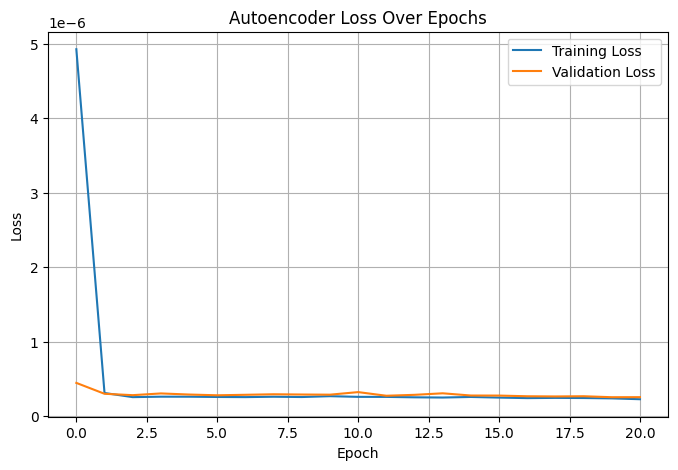

In [30]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Calcul des métriques
rmse = test_rmse
rpd = np.std(Y_test) / rmse
relative_error = rmse / np.mean(Y_test)

# Préparation de la nouvelle ligne
new_row = pd.DataFrame({
    "Modèle": [Modd],
    "Variable": [Var],
    "RMSE": [rmse],
    "RE": [relative_error],
    "RPD": [rpd]
})

# Chemin vers ton fichier CSV
csv_path = "C:/Users/Administrator/Desktop/PFE/otha/results/resultats_CAE.csv"

# Si le fichier existe déjà, on l'ouvre et on ajoute la nouvelle ligne
if os.path.exists(csv_path):
    existing_results = pd.read_csv(csv_path)
    updated_results = pd.concat([existing_results, new_row], ignore_index=True)
else:
    # Si le fichier n'existe pas encore, on crée un nouveau fichier avec juste cette ligne
    updated_results = new_row

# Sauvegarde
updated_results.to_csv(csv_path, index=False, sep=',')
updated_results

,Modèle,Variable,RMSE,RE,RPD
0,CAE,adf,9.591372,0.288622,1.041004
